# Exploring SARIMAX analysis for forecasting internal JVM memory consumption in Kubernetes clusters

In this lab report, we will explore the feasibility of utilizing the internal memory usage of a JVM application to forecast the future need and use of resources. This will eventually allow auto-scaling JVM apps in Kubernetes clusters.

We got the data about internal JVM memory usage in a Prometheus server. From there we extracted it in a series of files named `liferaywww-memory_used_bytes*.csv`. These files contain measurements of the internal JVM memory usage (i.e., how much memory actually used for heap and non-heap) collected around every 2 minutes or so.

Below, we load these files from Google Drive:

In [1]:
import glob
from pathlib import Path
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive', force_remount=False)
files_dir = '/content/drive/MyDrive/liferaywww-notes/liferaywww-memory_used_bytes/'


dfs = []
for f in glob.glob(f'{files_dir}/*'):
  print(f'\rprocessing {f}', end='', flush=True)
  file_df = pd.read_csv(f)
  # The data include both values for the heap and non-heap memory.
  # We will focus on heap memory.
  file_df.drop(file_df[file_df['metric:area'] != 'heap'].index, inplace=True)
  file_df.drop([
      'metric_kind',
      'value_type',
      'resource_type',
      'end_time',
      'metric:top_level_controller_name',
      'metric:top_level_controller_type',
      'resource:job',
      'resource:project_id',
      'resource:cluster',
      'resource:namespace',
      'resource:location',
  ], axis=1, inplace=True)
  file_df['start_time'] = pd.to_datetime(file_df['start_time'], format='ISO8601')
  file_df['log_value'] = np.log(file_df['value'])
  # When we remove the fields that do not matter for us, we get many repeated
  # rows
  file_df.drop_duplicates(inplace=True, keep='first')
  dfs.append(file_df)
df = pd.concat(dfs).sort_values(by='start_time')
df.set_index('start_time')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
processing /content/drive/MyDrive/liferaywww-notes/liferaywww-memory_used_bytes/liferaywww-memory_used_bytes-2025-09-14T23:00.csv

,metric_type,value,metric:pod,metric:area,resource:instance,log_value
start_time,,,,,,
2025-09-01 00:00:45.533000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,3.068940e+09,liferay-8d8496454-r9lr8,heap,liferay-8d8496454-r9lr8:15000,21.844598
2025-09-01 00:01:35.171000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,4.908189e+09,liferay-8d8496454-x7d88,heap,liferay-8d8496454-x7d88:15000,22.314171
2025-09-01 00:01:58.908000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,4.369296e+09,liferay-8d8496454-2srk7,heap,liferay-8d8496454-2srk7:15000,22.197868
2025-09-01 00:02:45.533000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,5.955647e+09,liferay-8d8496454-r9lr8,heap,liferay-8d8496454-r9lr8:15000,22.507606
2025-09-01 00:03:35.171000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,7.125857e+09,liferay-8d8496454-x7d88,heap,liferay-8d8496454-x7d88:15000,22.686996
...,...,...,...,...,...,...
2025-09-14 23:59:22.604000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,2.578391e+09,liferay-75f8466b96-ldml6,heap,liferay-75f8466b96-ldml6:15000,21.670431
2025-09-14 23:59:26.072000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,4.255082e+09,liferay-75f8466b96-76vxz,heap,liferay-75f8466b96-76vxz:15000,22.171380
2025-09-14 23:59:30.955000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,5.930275e+09,liferay-75f8466b96-ptxlw,heap,liferay-75f8466b96-ptxlw:15000,22.503336


## Data clean-up steps

Note that we did the following operations to clean up the data:
1. removed columns that did not matter for us.
2. removed duplicated lines (since once we removed some columns, many lines lost whatever distinguished them).
3. got only rows with data relative to the heap memory (we do not care about non-heap usage at the moment).

We also did some data transformation to help our analysis
1. Converted the start time into a date value.
2. Made the start time the index of the data frame.
3. Create a `log_value` column with the log of the value. Since our value is on the scale of billions (we are dealing with gigabytes) this will be more tractable.

## Exploratory analysis

We had originally over six million data points, now we have around seventy thousand. This is probably more than enough. For agility, anyway, we will get a sample for exploratory purposes.

In [2]:
sample_size = 10000
sample = df.sample(n=sample_size, random_state=42)
sample.sort_values(by='start_time', inplace=True)
sample.set_index('start_time', inplace=True)
sample

,metric_type,value,metric:pod,metric:area,resource:instance,log_value
start_time,,,,,,
2025-09-01 00:03:35.171000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,7.125857e+09,liferay-8d8496454-x7d88,heap,liferay-8d8496454-x7d88:15000,22.686996
2025-09-01 00:21:58.908000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,6.503725e+09,liferay-8d8496454-2srk7,heap,liferay-8d8496454-2srk7:15000,22.595641
2025-09-01 00:23:58.908000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,7.404146e+09,liferay-8d8496454-2srk7,heap,liferay-8d8496454-2srk7:15000,22.725306
2025-09-01 00:26:45.533000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,3.832309e+09,liferay-8d8496454-r9lr8,heap,liferay-8d8496454-r9lr8:15000,22.066733
2025-09-01 00:36:45.533000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,3.219819e+09,liferay-8d8496454-r9lr8,heap,liferay-8d8496454-r9lr8:15000,21.892591
...,...,...,...,...,...,...
2025-09-14 23:49:51.119000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,3.244440e+09,liferay-75f8466b96-29hs6,heap,liferay-75f8466b96-29hs6:15000,21.900209
2025-09-14 23:50:44.817000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,3.084140e+09,liferay-75f8466b96-95499,heap,liferay-75f8466b96-95499:15000,21.849539
2025-09-14 23:51:30.955000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,6.389424e+09,liferay-75f8466b96-ptxlw,heap,liferay-75f8466b96-ptxlw:15000,22.577910


Let's plot the values of this sample to get some idea of the format of our time series:

In [3]:

import numpy as  np
import plotly.graph_objects as go
from plotly.express import colors

fig = go.Figure()

pods = sample['metric:pod'].unique()

def get_color(i):
  color_sequence = colors.qualitative.Plotly
  return color_sequence[i % len(color_sequence)]

for i, pod in enumerate(pods):
  subset_df = sample[sample['metric:pod'] == pod]
  fig.add_trace(
      go.Scatter(
          x=subset_df.index,
          y=subset_df['value'].values,
          mode='markers',
          fillcolor=get_color(i),
          name=pod
      )
  )

fig.show()


We notice the memory usage can go from under 1 GB to over 10 GB.

The question that mostly interest us is, can we use time series analysis to anticipate resource usage, even for different instances (pods) in the future? We can investigate it by training e.g. an ARIMA model with points from some pods, and validate it with other pods.

To use ARIMA, however, we need to have some idea of periodicity, so we will explore the autocorrelation function (ACF) over our data. First, we get the points from the first pod:

In [4]:
pod0_df = df[df['metric:pod'] == pods[0]]
pod0_df.set_index('start_time', inplace=True)
pod0_df

,metric_type,value,metric:pod,metric:area,resource:instance,log_value
start_time,,,,,,
2025-09-01 00:01:35.171000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,4.908189e+09,liferay-8d8496454-x7d88,heap,liferay-8d8496454-x7d88:15000,22.314171
2025-09-01 00:03:35.171000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,7.125857e+09,liferay-8d8496454-x7d88,heap,liferay-8d8496454-x7d88:15000,22.686996
2025-09-01 00:05:35.171000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,4.382492e+09,liferay-8d8496454-x7d88,heap,liferay-8d8496454-x7d88:15000,22.200883
2025-09-01 00:07:35.171000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,3.238710e+09,liferay-8d8496454-x7d88,heap,liferay-8d8496454-x7d88:15000,21.898441
2025-09-01 00:09:35.171000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,3.493193e+09,liferay-8d8496454-x7d88,heap,liferay-8d8496454-x7d88:15000,21.974082
...,...,...,...,...,...,...
2025-09-01 19:35:35.171000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,4.714974e+09,liferay-8d8496454-x7d88,heap,liferay-8d8496454-x7d88:15000,22.274009
2025-09-01 19:37:35.171000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,9.795904e+09,liferay-8d8496454-x7d88,heap,liferay-8d8496454-x7d88:15000,23.005230
2025-09-01 19:39:35.171000+00:00,prometheus.googleapis.com/jvm_memory_used_byte...,5.546808e+09,liferay-8d8496454-x7d88,heap,liferay-8d8496454-x7d88:15000,22.436488


Since this specific instance ran from September 9 to Semptember 14, it is very comprehensive. Let's use ACF plot to analyse its time series:[link text](https://)

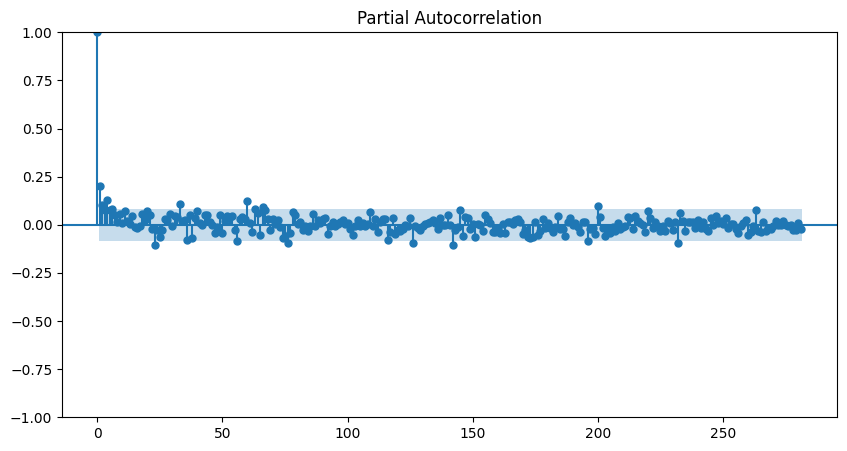

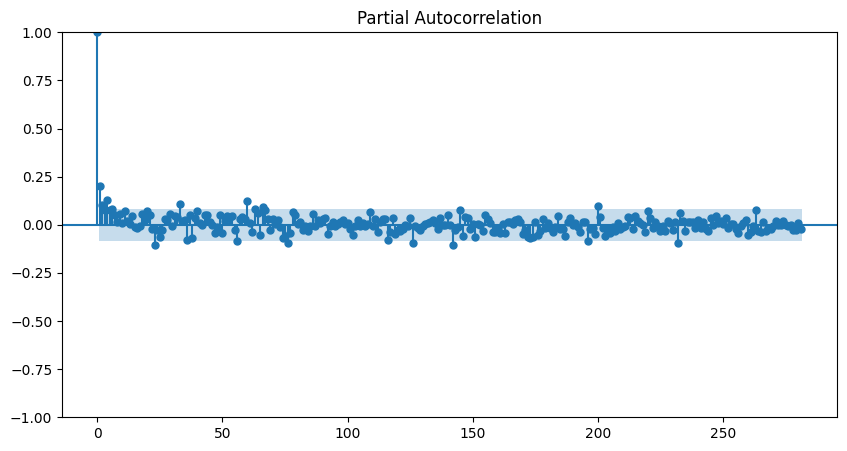

In [5]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf

import matplotlib.pyplot as plt

# Create the ACF plot
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(
    pod0_df['log_value'],
    ax=ax,
    lags=281,            # Same number of lags as the calculation
    alpha=0.05          # Significance level (95% confidence)
)

No long lag seems promising, the higher correlations appear to happen close to the smaller lags. Let's explore them:

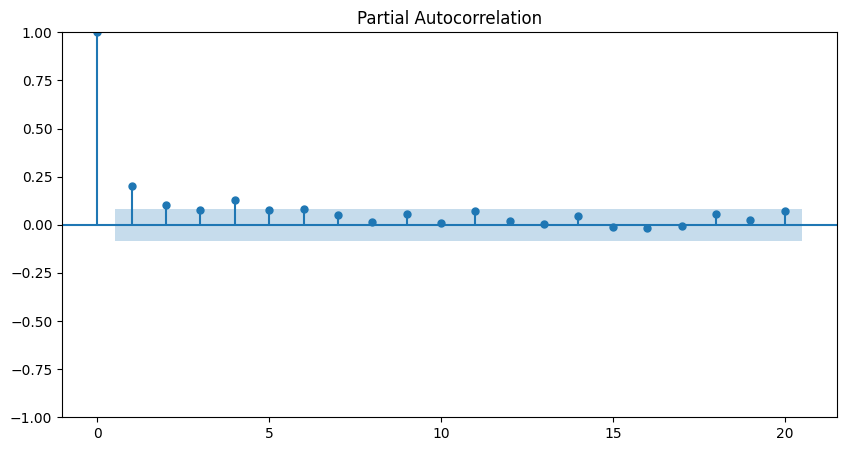

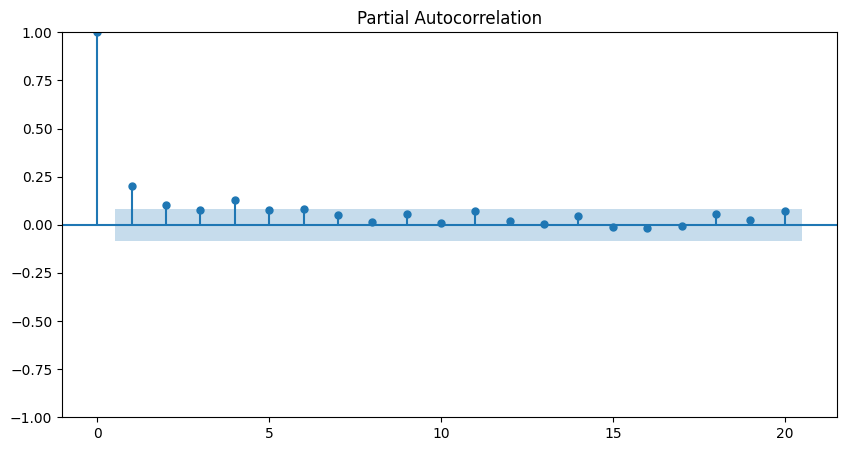

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(
    pod0_df['log_value'],
    ax=ax,
    lags=20,            # Same number of lags as the calculation
    alpha=0.05          # Significance level (95% confidence)
)

Clearly, the higher correlation is with the previous reading (that usually happened 2 minutes before). After that, there is a correlation with fourth lag; while it is smaller, we will use it because we want to have as much anticipation as possible:

In [7]:
import statsmodels.api as sm

# 1. Define parameters. We experimented with a few ones before
p_val = 0
d_val = 1
q_val = 1

P_val = 0
D_val = 1
Q_val = 1
S_val = 4

# 2. Instantiate the SARIMAX model
model = sm.tsa.SARIMAX(
    pod0_df['log_value'],
    order=(p_val, d_val, q_val),
    seasonal_order=(P_val, D_val, Q_val, S_val),
    enforce_stationarity=False, # Set to True if you already differenced the data
    enforce_invertibility=False
)

# 3. Fit (Train) the model
results = model.fit()

# 4. Review the results
print(results.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                     SARIMAX Results                                     
Dep. Variable:                         log_value   No. Observations:                  562
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -82.503
Date:                           Fri, 10 Oct 2025   AIC                            171.005
Time:                                   20:21:42   BIC                            183.940
Sample:                                        0   HQIC                           176.060
                                           - 562                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9273      0.018    -50.988      0.000      -0.963      -0.892
ma.S.L4       -1.0135      0.021    -48.775

We got a workable model, although there are points for improvement. (The heteroscedasticity is quite high, for example). But it is a start.

## Validating against different pods

The question is: this model was trained with data from only one pod instance. How well would it model other instances' behavior? Let's validate the model with data from other instances.

For that, we will get data points from another pod. SARIMAX cannot forecast values past from its training data, so we will drop any points that happened before the latest one from the training data.

In [8]:
training_max_time = pod0_df.index.max()

pod1_df = df[df['metric:pod'] == pods[1]].sort_values(by='start_time')
pod1_df = pod1_df[pod1_df['start_time'] > training_max_time]

With that, we forecast values, and compare the forecasted values to the corresponding ones from the validating data.

In [9]:
from sklearn.metrics import mean_squared_error


start = len(pod0_df) +1
end = start + len(pod1_df)

log_forecast = results.predict(
  start=start,
  end=end
)

forecast = np.exp(log_forecast)

pod0_df

forecast
rmse = np.sqrt(mean_squared_error(pod1_df['value'].iloc[range(len(forecast)-1)], forecast[1:].values))
rmse


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



np.float64(11454285585.430798)

The root mean square error is close to the highest value of memory usage of 10 GB! Even the first analysis indicates that a SARIMAX model does not translate to a good forecast for different pods memory usage.

## Analysis

Why the bad result? It was not unthinkable, anyway: it is reasonable to imagine different instances of a service having different behavior. But there are some more factors. Maybe the time series we ussed for training (the memory usage from one pod only) was too short to capture real seasonality.

More aggravantly, we noticed that SARIMAX, as a time-series model, does not depend of the current status of the pod. This discards basically all relevant information we have.

## Conclusion

We believe that using a time series analysis algorithm may be too brittle for the problem at hand. We cogitate the possibility of using something like SARIMAX to find patterns, but it would only make sense over longer intervals. More relevant, though, is to leverage the information of the current state of the system. For this reason, we advise against relying in TSA for anticipating resource usage.

In [10]:
pod1_df['value'].iloc[range(len(forecast)-1)]

,value
4,9.244899e+08
3,1.126030e+09
2,1.064326e+09
1,9.883154e+08
0,1.401619e+09
...,...
56,4.234290e+09
55,6.306304e+09
54,6.794747e+09
53,6.980200e+09
